# Analiza danych z Google Trends

In [3]:
import sys
#zainstalowanie pytrends dla tego notebooka
!{sys.executable} -m pip install pytrends 
#zainstalowanie yfinance dla tego notebooka
!{sys.executable} -m pip install yfinance 

import numpy as np
import pandas as pd
from pytrends.request import TrendReq
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from pytrends import dailydata
import yfinance as fin
from datetime import datetime

pytrends = TrendReq(hl = 'PL')

### Ograniczenia

#### Normalizacja
Na początku warto zazanczyć, że dane z serwisu są normalizowane:

*Liczby reprezentują poszczególne zainteresowania w wyszukiwaniu względem najwyższego punktu na wykresie. Wartość 100 oznacza najwyższą popularność hasła. Wartość 50 oznacza, że popularność hasła była dwukrotnie mniejsza. Wartość 0 wskazuje, że dla danego hasła nie ma wystarczających danych.* - Google Trends

To znacznie ogranicza możliwości analizy tych danych. Oznacza to, że popularność wyszukiwania poszczególnych haseł możemy porównywać jedynie w ramach wspólnych zapytań, które z kolei ograniczone są do pięciu haseł.

Normalizacja wartościami całkowitymi z zakresu 0-100 wpływa również negatywnie na dokładność danych i możliwość ich analizy. Jeżeli chcemy porównać dwa hasła znacznie różniące sie pod względem popularności, wyniki dla mniej popularnego hasła będą w jeszcze mocniej ograniczonym zakresie i nie będą w żaden sposób użyteczne.

Przykładowo, powiedzmy że chcemy porównać jak zmieniała się popularność serwisu NaszaKlasa względem Facebook'a w ostatnich pięciu latach.

In [59]:
pytrends.build_payload(kw_list = ["nasza klasa", "facebook"], cat=0, timeframe='today 5-y', geo='PL', gprop='')
df1 = pytrends.interest_over_time()
df1.describe()

,nasza klasa,facebook
count,261.000000,261.000000
mean,0.616858,75.659004
std,0.600275,14.415090
min,0.000000,49.000000
25%,0.000000,63.000000
50%,1.000000,75.000000
75%,1.000000,88.000000
max,2.000000,100.000000


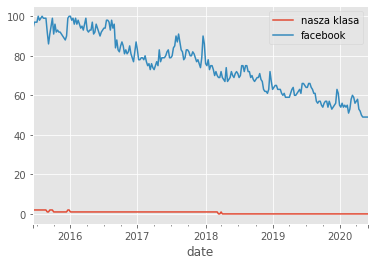

In [60]:
df1.plot()

Jak widać, dane dla wyszukiwań "nasza klasa" przyjmują wartości 0/1/2 dla okresu 5 lat i są właściwie bezużyteczne.
Aby otrzymać sensowne dane dla tego hasła, musimy stworzyć dla niego osobne zapytanie. Wtedy jednak, nie jesteśmy w stanie bezpośrednio porównać popularności dwóch haseł. 

#### Dokładność pomiaru
Kolejne ograniczenie dotyczy faktu, że dokładność pomiaru jest zależna od przedziału czasu jaki wybierzemy. Nie możemy jej ręcznie ustawić. Przykładowo, jeżeli chcemy otrzymać dane z dokładnością do godzin, maksymalny zakres czasu jaki możemy wybrać to tydzień. Ponieważ dane są normalizowane względem najwyższego wyniku w danym przedziale czasu, nie możemy zwyczajnie skleić kilku zapytań - musimy na nowo normalizować dane. 

Artykuł wyjaśniający w jaki sposób łączyć zapytania i normalizować dane, aby otrzymać dokładniejsze dane dla większych przedziałów czasu: https://medium.com/@bewerunge.franz/google-trends-how-to-acquire-daily-data-for-broad-time-frames-b6c6dfe200e6

### Tworzenie własnych funkcji na bazie pytrends

Używając Python'a, możemy obejść niektóre ograniczenia Google Trends.

Poniższa funkcja pozwala przeprowadzić zapytanie dla dowolnej liczby haseł. Działanie funkcji na zlepianiu wielu zapytań w jedno, gdzie wspólnym czynnikiem jest hasło z największą maksymalną popularnością spośród wszystkich.

In [61]:
#funkcja łącząca zapytania dla wielu haseł
#najpierw szukamy hasła z największym pikiem
#następnie łączymy zapytania po 5 (chyba że zostanie reszta), gdzie wspólnym czynnikiem jest wcześniej znalezione hasło
def better_compare(kw_list, cat, timeframe, geo, gprop):
    
    pytrends = TrendReq()
    n = len(kw_list)   #oblicznie iteratora do pętli
    if n > 5:
        k = 5
    else:
        k = n

    r = (n - 1) % 4 + 1  #reszta, która będzie obsługiwana poza główną pętlą 
    
    arr1 = [None] * k #lista używana w pętli
    arr2 = [None] * r #lista używana dla reszty
    arr1[0] = kw_list[0] #pierwszy element listy przechowuje najpopularniejsze dotychczas hasło
    
    max_val = 0
    
    #szukanie najpopularniejszego hasła w pętli  
    for i in range(1,n - r,4): 
        
        for j in range(1, k):
            arr1[j] = kw_list[i + j - 1]
    
        pytrends.build_payload(kw_list = arr1, cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
        df1 = pytrends.interest_over_time().drop('isPartial', axis=1)
        arr1[0] = df1.max().idxmax() # nazwa kolumny z największą wartością, czyli 100
            
    arr2[0] = arr1[0]
            
    #szukanie najpopularniejszego hasła w reszcie 
    for j in range(1, r):
        arr2[j] = kw_list[n - r + j]
    
    pytrends.build_payload(kw_list = arr2, cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
    df1 = pytrends.interest_over_time().drop('isPartial', axis=1)
    arr1[0] = df1.max().idxmax()   
    arr2[0] = arr1[0]
    
    #df2 jest naszą tablicą wynikową
    #najpierw wsadzamy do niej nwyniki dla najpopularniejszego hasła, a potem dokładamy kolejne
    pytrends.build_payload(kw_list = [arr1[0]], cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
    df2 = pytrends.interest_over_time().drop('isPartial', axis=1)
    
    #dokładanie wyników do df2 w pętli
    for i in range(0, n - r ,4):
        for j in range(1, k):
            if kw_list[i + j - 1] == arr1[0]:
                continue
            arr1[j] = kw_list[i + j - 1]
        
        pytrends.build_payload(kw_list = arr1, cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
        df1 = pytrends.interest_over_time().drop('isPartial', axis=1)
        df2 = pd.concat([df2, df1.drop(arr1[0], axis=1)], axis=1)  
        
    #dokładanie wyniów do df2 dla haseł z reszty
    for j in range(1, r):
        if kw_list[n - r + j] == arr2[0]:
                continue
        arr2[j] = kw_list[n - r + j]
        
    pytrends.build_payload(kw_list = arr2, cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
    df1 = pytrends.interest_over_time().drop('isPartial', axis=1)
        
    df2 = pd.concat([df2, df1.drop(arr1[0], axis=1)], axis=1)   
    
    return df2

Przykład działania funkcji:

In [62]:
df2 = better_compare(kw_list = ['Arkadiusz Milik', 'Piotr Zieliński', 'Krzysztof Piątek', 'Grzegorz Krychowiak', 'Wojciech Szczęsny', 'Kamil Grosicki', 'Łukasz Piszczek', 'Jakub Błaszczykowski', 'Kamil Glik'], cat=0, timeframe='today 5-y', geo='PL', gprop='')
df2.head()

,Jakub Błaszczykowski,Arkadiusz Milik,Piotr Zieliński,Krzysztof Piątek,Grzegorz Krychowiak,Wojciech Szczęsny,Kamil Grosicki,Łukasz Piszczek,Grzegorz Krychowiak
date,,,,,,,,,
2015-06-14,4,10,2,0,6,3,2,3,7
2015-06-21,1,1,1,1,3,5,2,2,3
2015-06-28,2,1,1,0,2,4,0,1,2
2015-07-05,1,2,2,1,1,10,1,2,2
2015-07-12,1,2,1,1,2,5,2,1,2


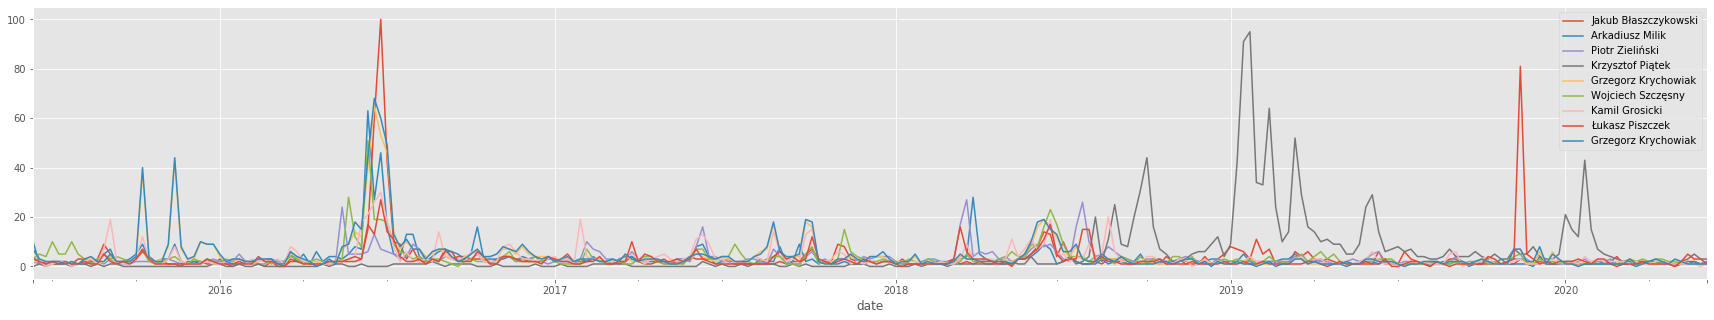

In [63]:
df2.plot(figsize = (30, 5))

Kolejną funkcją, którą możemy dodać jest funkcja zlepiająca dane z indywidualnych zapytań dla poszeczególnych haseł. Oznacza to, że dane dla każdego hasła są znormalizowane względem największego wyniku tego hasła. O ile takie dane nie pozwalają na porównywanie popularnośći haseł, to możemy łatwo porównać zależności pomiędzy poszczególnymi hasłami. Mniej popularne hasła nie są bowiem spłaszone pod wpływem tych znacznie bardziej popularnych.

In [64]:
#funkcja łącząca indywidulane zapytania dla haseł z listy

def join_ind_payloads(kw_list, cat, timeframe, geo, gprop):
    
    pytrends = TrendReq(hl='PL')
    df = pd.DataFrame(data={}) #tworzymy pustą ramkę
    
    #umieszczamy dane dla każdego kolejnego hasła w ramce
    for kw in kw_list:
        pytrends.build_payload(kw_list = [kw], cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
        df[kw] = pytrends.interest_over_time()[kw]

    return df

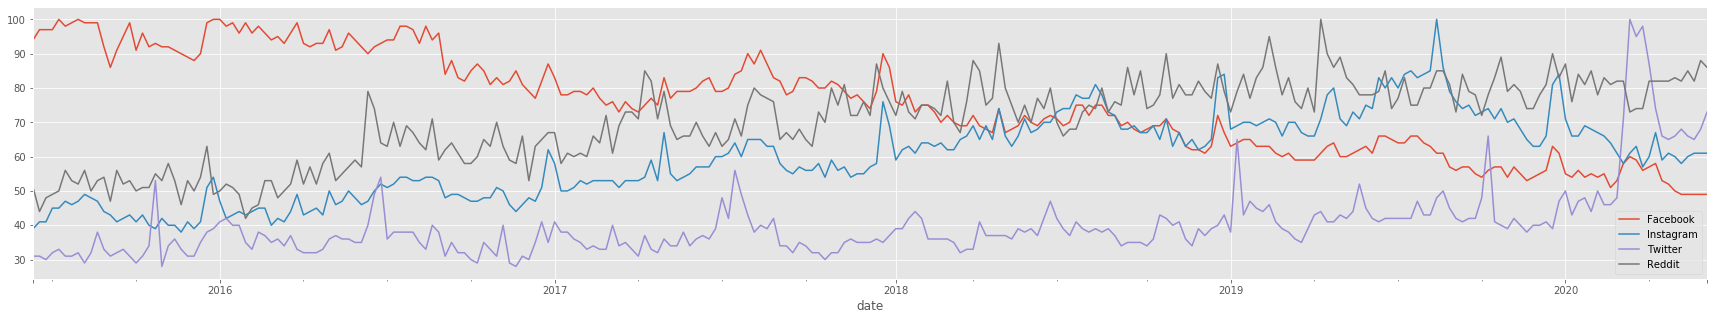

In [65]:
join_ind_payloads(kw_list = ['Facebook', 'Instagram', 'Twitter', 'Reddit'], cat=0, timeframe='today 5-y', geo='PL', gprop='').plot(figsize = (30, 5))

## Wykorzystania danych GT w analizie

Dane z Google Trends pozwalają, w podstawowym zakresie:
- zobaczyć zmiany popularności haseł w czasie
- porównać zmiany popularności kilku haseł
- porównać poziom popularności kilku haseł
- porównać popularność haseł w konkretnych regionach

Przykładowo, możemy użyć tych danych do zbadania popularności rzeczy na przestrzeni roku.

#średnia ruchoma

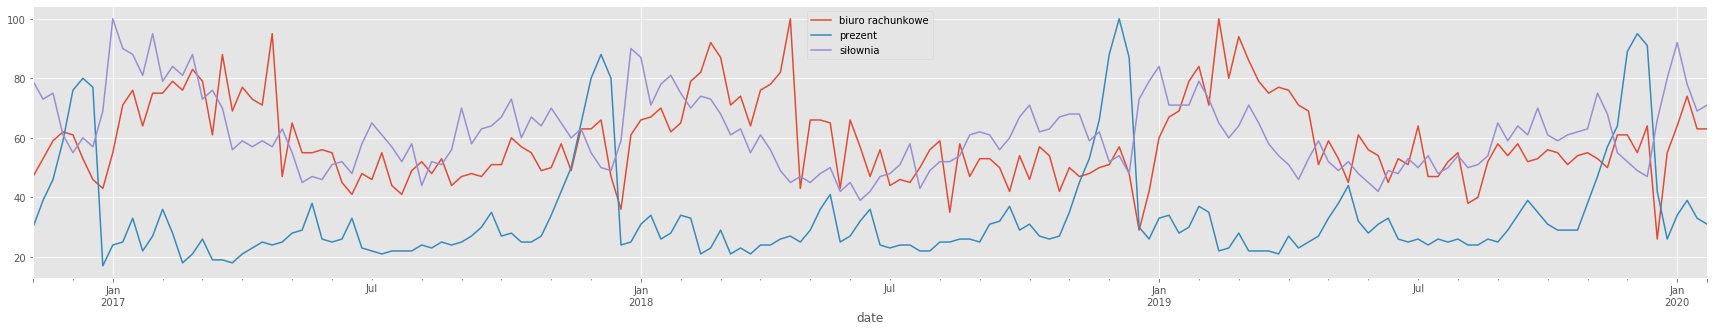

In [66]:
join_ind_payloads(kw_list = ['biuro rachunkowe', 'prezent', 'siłownia'], cat=0, timeframe='2016-11-01 2020-02-01', geo='PL', gprop='').plot(figsize = (30, 5))

Z wykresu możemy wywnioskować, że:
- Najczęściej wyszukujemy prezenty w okresie świąt Bożego Narodzenia, ale także na walentynki, w okresie komunii świętych oraz na dzień dziecka.
- Popularność biur rachunkowy rośnie wraz ze zbliżaniem się terminu zeznania podatkowego.
- Największą popularność siłownie mają wraz z początkiem roku, kiedy ludzie robią postanowienia noworoczne.

Nie będziemy się jednak skupiać na podstawowych funkcjonalnościach serwisu. Korzystając z danych Google Trends możemy bowiem przeprowadzić bardziej konkretną i zaawansowaną analizę. Poniżej zostaną omówione niektóre sposoby ciekawego wykorzystania danych udostępnianych przez serwis.

### Badanie trendów względem regionu
Google Trends pozwala porównać popularność haseł w konkretnych regionach, jednak nie pozwala zbadać jak zmieniała się popularność danego hasła w czasie dla danych regionów. Poniżej znajduje się funckja, która nam na to pozwoli.

In [67]:
#funkcja łącząca zapytania dla różnych regionów

def popularity_change_by_region(kw, cat, timeframe, geo_list, gprop):
    # kw - hasło, dla którego wyszukjemy wyniki
    # geo_list - lista regionów
    # '' w geo_list to cały świat - musi być na początku listy (z niewyjaśnionych przyczyn)

    pytrends = TrendReq(hl = 'PL')
    df = pd.DataFrame(data={})
    
    # Umieszczamy zapytania dla kolejnych regionów w ramce
    for geo in geo_list:
        pytrends.build_payload(kw_list = [kw], cat=cat, timeframe=timeframe, geo=geo, gprop = gprop)
        if geo == '':
            df['Worldwide'] = pytrends.interest_over_time()[kw]
        else:
            df[geo] = pytrends.interest_over_time()[kw]

    return df

Funkcja będzie dawała poprawne wyniki jedynie dla haseł uniwersalnych w różnych językach (chyba, że wyszukujemy dla podregionów danego kraju) lub dla tematów.

Przy pomocy tej funkcji możemy na przykład zauważyć z jakim opóźnieniem kształtują się trendy z zachodu na świecie i w naszym kraju.

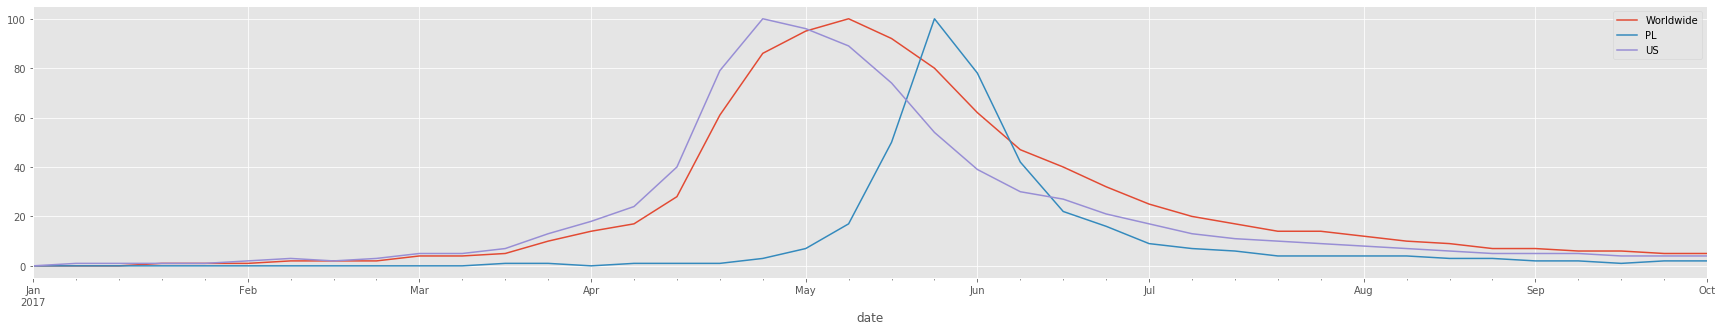

In [68]:
popularity_change_by_region(kw = "fidget spinner", cat=0, timeframe="2017-01-01 2017-10-01", geo_list=['', 'PL', 'US'], gprop='').plot(figsize = (30, 5))

Jak widać z wykresu, trend w postaci fidget spiner'ów był w USA najsilniejszy pod koniec kwietnia i dopiero wtedy w Polsce zaczęły one zyskiwać popularność. Pik ich popularności na świecie nastąpił około 2 tygodnie później, w Polsce natomiast miesiąc później niż w USA.

Możemy również sprawdzić jak kształtuje się popularność poszczególnych samochodów w danych krajach. W Polsce popularne jest sprowadzanie używanych samochodów z Niemiec. Powinno być zatem możliwe zobaczenie zależności w popularności pewnych starszych modeli aut pomiędzy dwoma krajami. Pik popularności w Polsce powinien być przesunięty w czasie względem Niemiec.
Zobaczmy wykres dla popularnego w Polsce Volkswagena Golf 4.

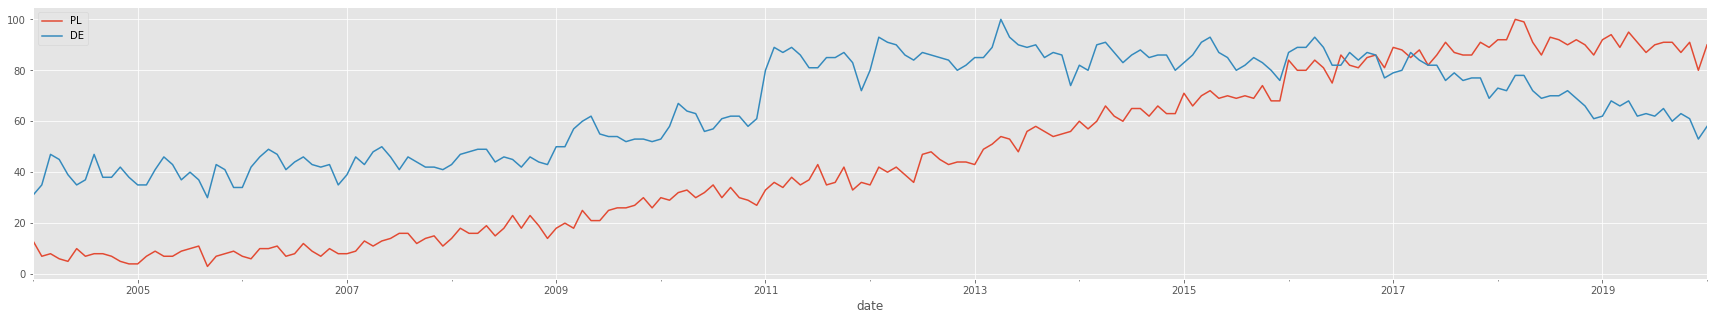

In [69]:
popularity_change_by_region(kw = "Golf 4", cat=0, timeframe="2004-01-01 2020-01-01", geo_list=['PL', 'DE'], gprop='').plot(figsize = (30, 5))

Z wykresu możemy zauważyć, że w Niemczech od paru lat odchodzi się od Golfa 4, zaś w Polsce jego popularność stale rosła aż do roku 2019. Pik w Polsce jest przesunięty o około 6 lat.

### Google Globe Trends
Na bazie projektu: https://github.com/chrisrzhou/google-globe-trends
możemy stworzyć własną interaktywną wizualizację danych z Google Trends na kuli ziemskiej, na kształt tej:
https://google-globe-trends.netlify.app/. Miasta na  świecie z największą liczbą wyszukiwań danego hasła są zaznaczone świecącym punktem. Popularność jest liczona dla okresu od 2004 do dziś.

Wygląd wizualizacji:
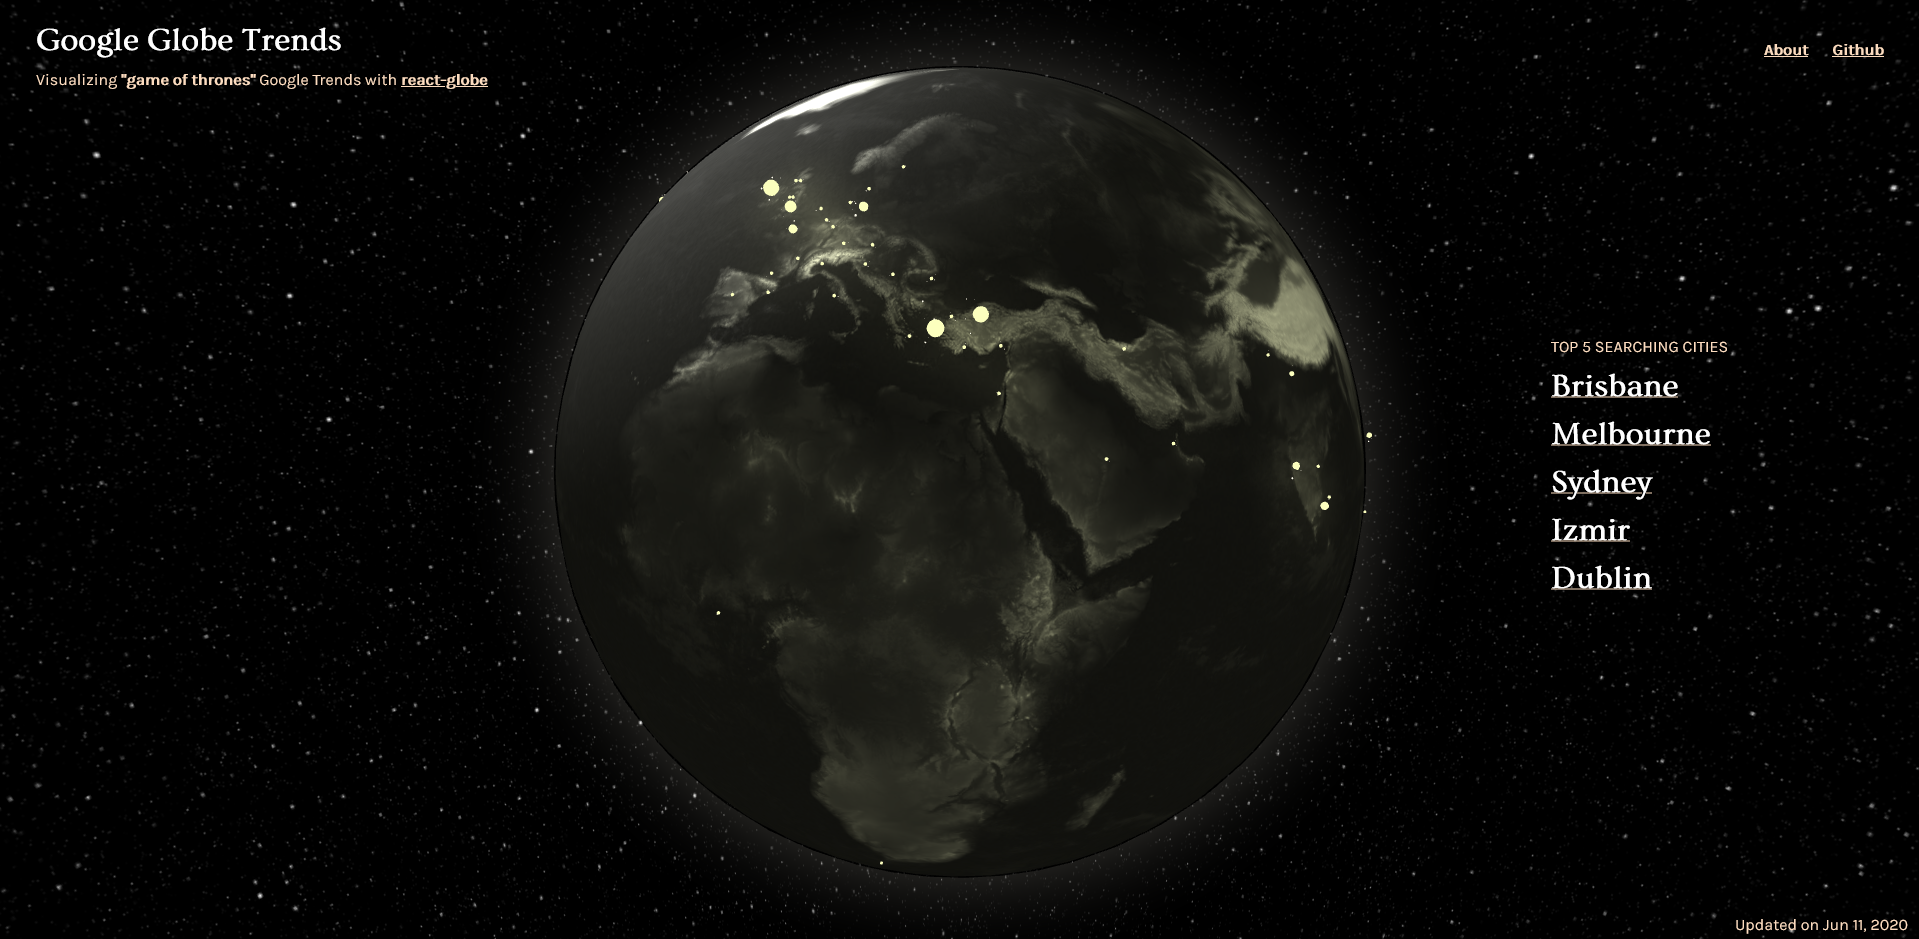

Aby skonfigurować własną wizualizację należy podążać za instrukcjami opisanymi w projekcie.
W skrócie należy:
1. Sklonować oryginalne repozytorium i umieścić je na Github'ie
2. Zmienić wartość data.keyword w pliku src/config.js na pożądane hasło
3. Połączyć aplikację Netlify z naszym repozytorium (*Deploy to netlify*)
4. Wdrożyć naszą wizualizację w Netlify
W wyniku mamy gotową aplikację webową.

Przykładowa wizualizacja, którą stworzyłem dla hasła "Iphone":
https://dazzling-hodgkin-f2e15a.netlify.app/

### Badanie poziomu smutku
Źródło: https://www.washingtonpost.com/news/wonk/wp/2014/12/03/the-google-misery-index-the-times-of-year-were-most-depressed-anxious-and-stressed/?arc404=true

Zakładając, że gdy ludzi są smutni, to częściej wyszukują w wyszukiwarce hasłą związane ze smutkiem, możemy użyć Google Trends aby zbadać jak zmienia się poziom szczęścia społeczeństwa na przestrzeni roku.

Na potrzeby poniższego wykresu stworzyliśmy wskaźnik nieszczęścia, na który składają się 4 tematy: Zaburzenia depresyjne, Smutek, Lęk oraz Stres.

Wykres smutku w Polsce 2019:


Text(0.5, 0, 'Data')

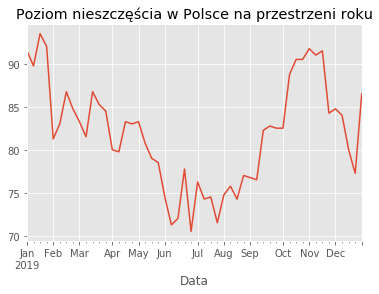

In [70]:
kw_misery = ["/m/02bft","/m/02y_3dj","/m/0k_9", "/m/012lyw"] #kody tematów

df = join_ind_payloads(kw_list = kw_misery, cat=0, timeframe='2019-01-01 2020-01-01', geo='PL', gprop='') # pobranie danych
df['Misery'] = df.mean(axis=1) #wskaźnik nieszczęścia jako średnia z poszczególnych tematów
df.Misery.plot(title ="Poziom nieszczęścia w Polsce na przestrzeni roku", legend=False).set_xlabel("Data") # wykres

Z wykresy widzimy, że wskaźnik nieszczęścia na początku roku jest wysoko. Wraz ze zbliżaniem się lata stopniowo maleje. W maju jest nagły wzrost - prawdopodobnie ze względu na matury. W lecie wskaźnik jest najniższy. Wraz z końcem lata mocno idzie w górę i osiąga pik w połowie października. Wraz ze zbliżaniem się świąt mocno spada, jednak po świętach znowu rośnie.

Poniżej przeprowadzono analizę dla poszczególnych dni tygodnia oraz godzin. W tym celu wykorzytsano funkcję get_historical_interest(), która zwraca wyniki z dokładnością do godziny.
Ze względu na bardzo dużą ilość danych, badamy jednak tylko temat "Smutek".

**UWAGA ODNOŚNIE PONIŻSZYCH WYKRESÓW:** Funkcja get_historical_interest() skleja wyniki z zapytań tygodniowych. Popularność dla poszczególnych godzin jest normalizowana względem najwyższego wyniku z danego tygodnia. Wynik popularności na poniższych wykresach to **średnia z wartości popularności dla danego dnia/godziny/obu względem najwyższego wyniku w tygodniu**. 

In [71]:
keyword = kw_misery[1] #temat "Smutek"
sadness = pytrends.get_historical_interest([keyword], year_start=2019, month_start=1, day_start=1, hour_start=0, year_end=2020, month_end=1, day_end=1, hour_end=0, cat=0, geo='PL', gprop='', sleep=0).drop('isPartial', axis=1, errors='ignore')

Text(0.5, 0, 'Dzień tygodnia')

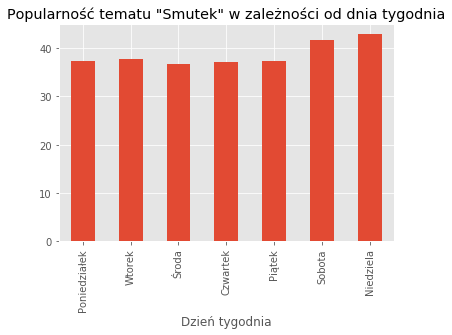

In [72]:
days_of_week = {
    0: 'Poniedziałek',
    1 : 'Wtorek',
    2 : 'Środa',
    3 : 'Czwartek',
    4 : 'Piątek',
    5 : 'Sobota',
    6 : 'Niedziela'}

sadness.groupby(sadness.index.dayofweek).mean().rename(columns={keyword: 'Smutek'}, index= days_of_week).plot(kind='bar',title ="Popularność tematu \"Smutek\" w zależności od dnia tygodnia", legend=False).set_xlabel("Dzień tygodnia")

Z wykresu kolumnowego dla poszczególnych dni tygodnia widać, że hasła związane ze smutkiem są najmniej popularne w weekend. Największa popularność przypada na wtorek. 

Analiza dla godzin:

Text(0.5, 0, 'Godzina')

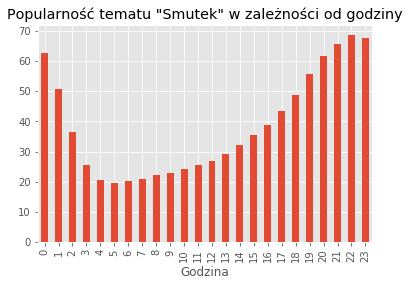

In [73]:
sadness.groupby(sadness.index.hour).mean().plot(kind='bar', title ="Popularność tematu \"Smutek\" w zależności od godziny", legend=False).set_xlabel("Godzina")

Widzimy, że hasła związane ze smutkiem są najczęściej wyszukiwane w okolicach północy i najrzadziej w ciągu dnia, zwłaszcza rano.

Możemy połączyć dwa powyższe wykresy na mapie ciepła, aby uzyskać jeszcze dokładniejszą analizę.

In [74]:
# tworzenie ramki danych do mapy ciepła
df7 = pd.DataFrame(index = range(0, 24))
j = 0
for d in list(days_of_week.values()): # dla każdego dnia
    df7[d] = "" # dodanie piustej kolumny dla danego dnia
    for i in df7.index: # dla każdej godziny
        df7.loc[i, d] = sadness[(sadness.index.hour == i) & (sadness.index.dayofweek == j)].mean()[0] # dodaj średnią z wyników dla danego dnia tyg. i godziny
    df7[d] = pd.to_numeric(df7[d])
    j += 1

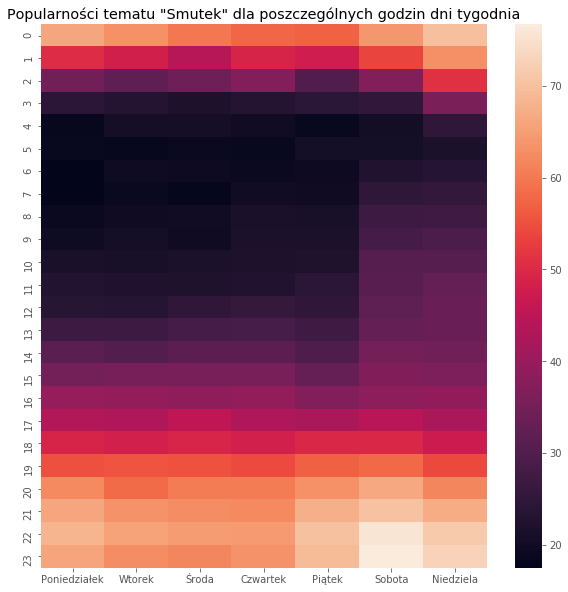

In [75]:
# tworzenie mapy ciepła
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Popularności tematu \"Smutek\" dla poszczególnych godzin dni tygodnia")
ax.set_ylabel("Godzina")
sns.heatmap(df7, ax = ax)

Z mapy ciepła możemy wyczytać, że Polacy najczęściej wyszukują hasła związne ze smutkiem w okolicach północy w środku tygodnia - szczególnie często w niedzielny wieczór. Z kolei najmniej zapytań jest w piątek i sobotę, w ciągu dnia.

### Badanie popularności koronawirusa względem liczby zachorowań
Źródło danych: https://data.europa.eu/euodp/pl/data/dataset/covid-19-coronavirus-data

Korzystając z danych dotyczących koronawirusa, możemy zwizualizować jak kształtowała się jego popularność w internecie względem liczby zakażeń. Liczba zakażeń jest znormalizowana w ten sam sposób, co dane popularności z Google Trends (0-100 względem najwyższego wyniku), aby wykres był bardziej czytelny.

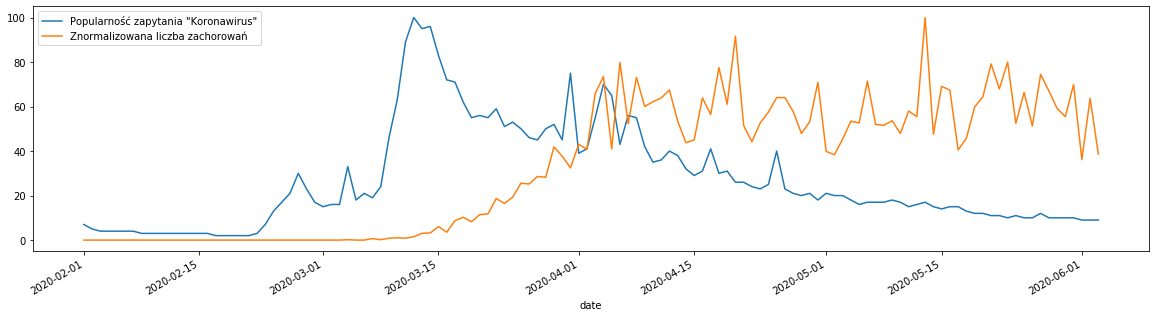

In [4]:
corona = pd.read_csv("corona.csv") # pobieramy dane, zawierające wszytskie dane
coronaPL = corona[corona.geoId == "PL"] # wybieramy tylko dane dla Polski

# dopasowujemy format daty danych koronawriusa, aby zgadzał się z danymi z Google Trends
coronaPL = pd.concat([coronaPL.apply(lambda row: dt.datetime(row.year, row.month, row.day), axis=1), coronaPL["cases"]], axis = 1)
coronaPL.set_index(0, inplace = True)
coronaPL.index.names = ["date"]

# pobieramy dane z Google Tredns i łączymy z danymi koronawirusa
pytrends.build_payload(kw_list = ["Koronawirus"], cat=0, timeframe="2020-02-01 2020-06-03", geo='PL', gprop = '')
df = pytrends.interest_over_time().drop('isPartial', axis=1)
df = df.join(coronaPL).fillna(0)

# normalizacja min-max liczby przypadków
minc = df['cases'].min()
maxc = df['cases'].max()
df['cases'] = df['cases'].map(lambda x: 100*(x - minc)/(maxc- minc))

# tworzenie wykresu
ax = df.plot(figsize = (20, 5), x_compat = True)
L=plt.legend()
L.get_texts()[0].set_text('Popularność zapytania "Koronawirus"')
L.get_texts()[1].set_text('Znormalizowana liczba zachorowań')
plt.show()

Na wykresie widać piki popularności koronawirusa powiązane z konkretnymi wydarzeniami:
- 27.02 - Doniesienia o pierwszym przypadku w łodzi: https://lodz.wyborcza.pl/lodz/7,35136,25736561,koronowirus-w-polsce-zarazona-25-latka-w-lodzi.html 
- 04.03 - Pierwszy potwierdzony przypadek zakażenia koronawirusem (2019-nCoV) w Polsce
- 12.03 - Pierwszy zgon
- 31.03 - Wprowadzenie nowych ograniczeń (m.in. zamknięcie parków): 
https://www.gov.pl/web/koronawirus/kolejne-kroki


Z wykresu możemy zauważyć, że zainteresowanie Polacy znudzili się koronawirusem, pomimo że liczba nowych przypadków wcale nie spada i zagrożenie wciąż jest realne. Polacy najbardziej byli zainteresowani wirusem na samym początku, kiedy potwierdzono w Polsce pierwszą ofiarę śmiertelną.


### Badanie popularności akcji giełdowych względem ich ceny
Źródło: https://makersportal.com/blog/2020/1/19/google-trends-x-yahoo-finance

Dane z Google Trends możemy wykorzystać także do analizy finansowej. Zamieszczony wyżej artykuł pokazuje w jaki sposób możemy zestawić popularność danych akcji w wyszukiwarce Google względem ich ceny. Autor wykorzystuje w tym celu pytrends oraz API yfinance, które pobiera dane giełdowe z Yahoo Stocks.

Poniżej wykorzystałem kod z artykułu, aby przedstawić zależność cen akcji Bitcoin'a od jego popularności w internecie. Przedstawiony jest również druki wykres obrazujący korelację pomiędzy tymi dwoma wartościami w czasie.



Bitcoin:2019-01-01 2019-01-31
Bitcoin:2019-02-01 2019-02-28
Bitcoin:2019-03-01 2019-03-31
Bitcoin:2019-04-01 2019-04-30
Bitcoin:2019-05-01 2019-05-31
Bitcoin:2019-06-01 2019-06-30
Bitcoin:2019-07-01 2019-07-31
Bitcoin:2019-08-01 2019-08-31
Bitcoin:2019-09-01 2019-09-30
Bitcoin:2019-10-01 2019-10-31
Bitcoin:2019-11-01 2019-11-30
Bitcoin:2019-12-01 2019-12-31
Bitcoin:2020-01-01 2020-01-31
[*********************100%***********************]  1 of 1 completed


C:\Users\krzys\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
C:\Users\krzys\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars


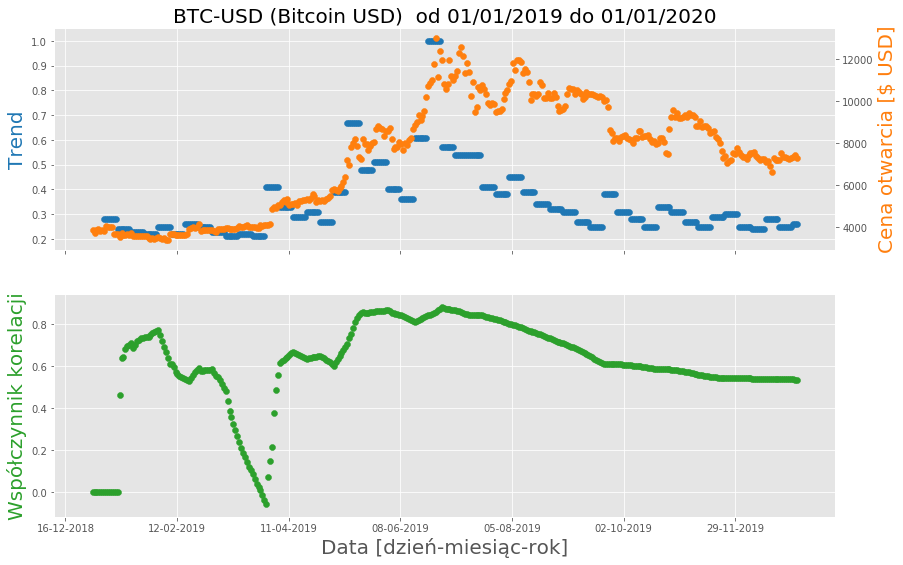

In [77]:
# Kod został lekko zmieniony względem oryginału (głównie zmiana podpisów osi i formatu daty na polskie)

# PARAMETRY
ticker = 'BTC-USD' # jakiej akcji szukamy
date_range = [1,1,2019,1,1,2020] # okres; format: dzień, miesiąc, rok

fin_indx = 0 # pokazujemy cenę otwarcia na wykresie
trend_indx = 3 #dane z GT są wyskalowane na wykresie względem ceny


# STWORZENIE ZMIENNYCH DLA OKRESU
start_t = dt.datetime(date_range[2],date_range[1],date_range[0])
end_t   = dt.datetime(date_range[5],date_range[4],date_range[3])

# POBRANIE DANYCH 
ticker_handle = fin.Ticker(ticker)
trends = dailydata.get_daily_data(ticker_handle.info.get('shortName').split(' ')[0],
                                  date_range[2],date_range[1],
                                  date_range[5],date_range[4])

fin_data = fin.download(ticker,start=start_t.strftime('%Y-%m-%d'),
                        end=end_t.strftime('%Y-%m-%d'))

# DOPASOWYWANIE DANYCH
fin_keys = fin_data.keys() # keys for naming plotted finance data
trend_keys = trends.keys() # keys for naming plotted trends data

fin_x   = [ii.timestamp() for ii in fin_data.index] # formatting dates into timestamp for plotting
fin_y   = (fin_data.values)[:,fin_indx] # trend data to plot

trend_x = [ii.timestamp() for ii in trends.index] # formatting dates into timestamp for plotting
trend_y = (trends.values)[:,trend_indx] # trend data to plot

trend_start_indx = np.argmin(np.abs(np.subtract(trend_x,fin_x[0])))
trend_end_indx   = np.argmin(np.abs(np.subtract(trend_x,fin_x[-1])))
trend_y = [trend_y[np.argmin(np.abs(np.subtract(ii,trend_x)))] for ii in fin_x] # align trends + stock $
trend_x = [trend_x[np.argmin(np.abs(np.subtract(ii,trend_x)))] for ii in fin_x] # align trends + stock $


# OBLICZANIE KORELACJI
corr_xy_array = [0.0]
for ii in range(1,len(fin_y)):
    mean_x = np.nanmean(trend_y[0:ii])
    mean_y = np.nanmean(fin_y[0:ii])
    sigma_x = np.sqrt(np.nansum(np.power(trend_y[0:ii]-mean_x,2.0)))
    sigma_y = np.sqrt(np.nansum(np.power(fin_y[0:ii]-mean_y,2.0)))
    corr_xy = (np.nansum(np.multiply((np.subtract(trend_y[0:ii],mean_x)),
                                     np.subtract(fin_y[0:ii],mean_y))))\
              /(sigma_x*sigma_y)
    if np.isnan(corr_xy):
        corr_xy = 0.0
    corr_xy_array.append(corr_xy)

# TWORZENIE WYKRESÓW
plt.style.use('ggplot')
fig,axs = plt.subplots(2,1,figsize=(14,9),sharex=True)

ax = axs[0]
ax.scatter(trend_x,trend_y,color=plt.cm.tab20(0))
ax2 = ax.twinx()
ax2.grid(False)
ax2.scatter(fin_x,fin_y,color=plt.cm.tab20(2))

ax.set_ylabel('Trend',color=plt.cm.tab20(0),fontsize=20)
ax2.set_ylabel('Cena otwarcia [$ USD]',color=plt.cm.tab20(2),fontsize=20)

ax3 = axs[1]
scat3 = ax3.scatter(fin_x,corr_xy_array,color=plt.cm.tab20(4))
ax3.set_ylabel('Współczynnik korelacji',
              fontsize=20,color=plt.cm.tab20(4))
x_ticks = ax3.get_xticks()
x_str_labels = [(dt.datetime.fromtimestamp(ii)).strftime('%d-%m-%Y') for ii in x_ticks]
ax3.set_xticklabels(x_str_labels) 
ax3.set_xlabel('Data [dzień-miesiąc-rok]',fontsize=20)
ax2.set_xticklabels(x_str_labels)

ax.set_title(ticker+' ({}) '.format(ticker_handle.info.get('shortName'))+' od {} do {}'.format(start_t.strftime('%d/%m/%Y'),
                                        end_t.strftime('%d/%m/%Y')),
          fontsize=20)

plt.show()

Widzimy, że przez większość roku utrzymuje się wyraźna dodatnia korelacja. Przez trzy miesiące współczynnik korelacji wynosił ponad 0.8. Oznacza to, że cena Bitcoin'a jest mocno powiązana z jego popularnością.

### Inne zastosowania danych Google Trends

#### "iPhone is slow" względem nowych IOS
Źródło: https://goodbrothers.digital/ideation/google-trends-the-story-goldmine-youre-probably-not-using-enough/

Mówi się, że Apple celowo spowalnia starsze Iphone'y, aby zmusić ludzi do kupienia nowszych model. Używając Google Trends możemy dowieść prawdziwości tej tezy. Poniżej znajduję się wizualizacja popularności hasła "Iphone slow" względem pojawiania się nowych wersji IOS. 
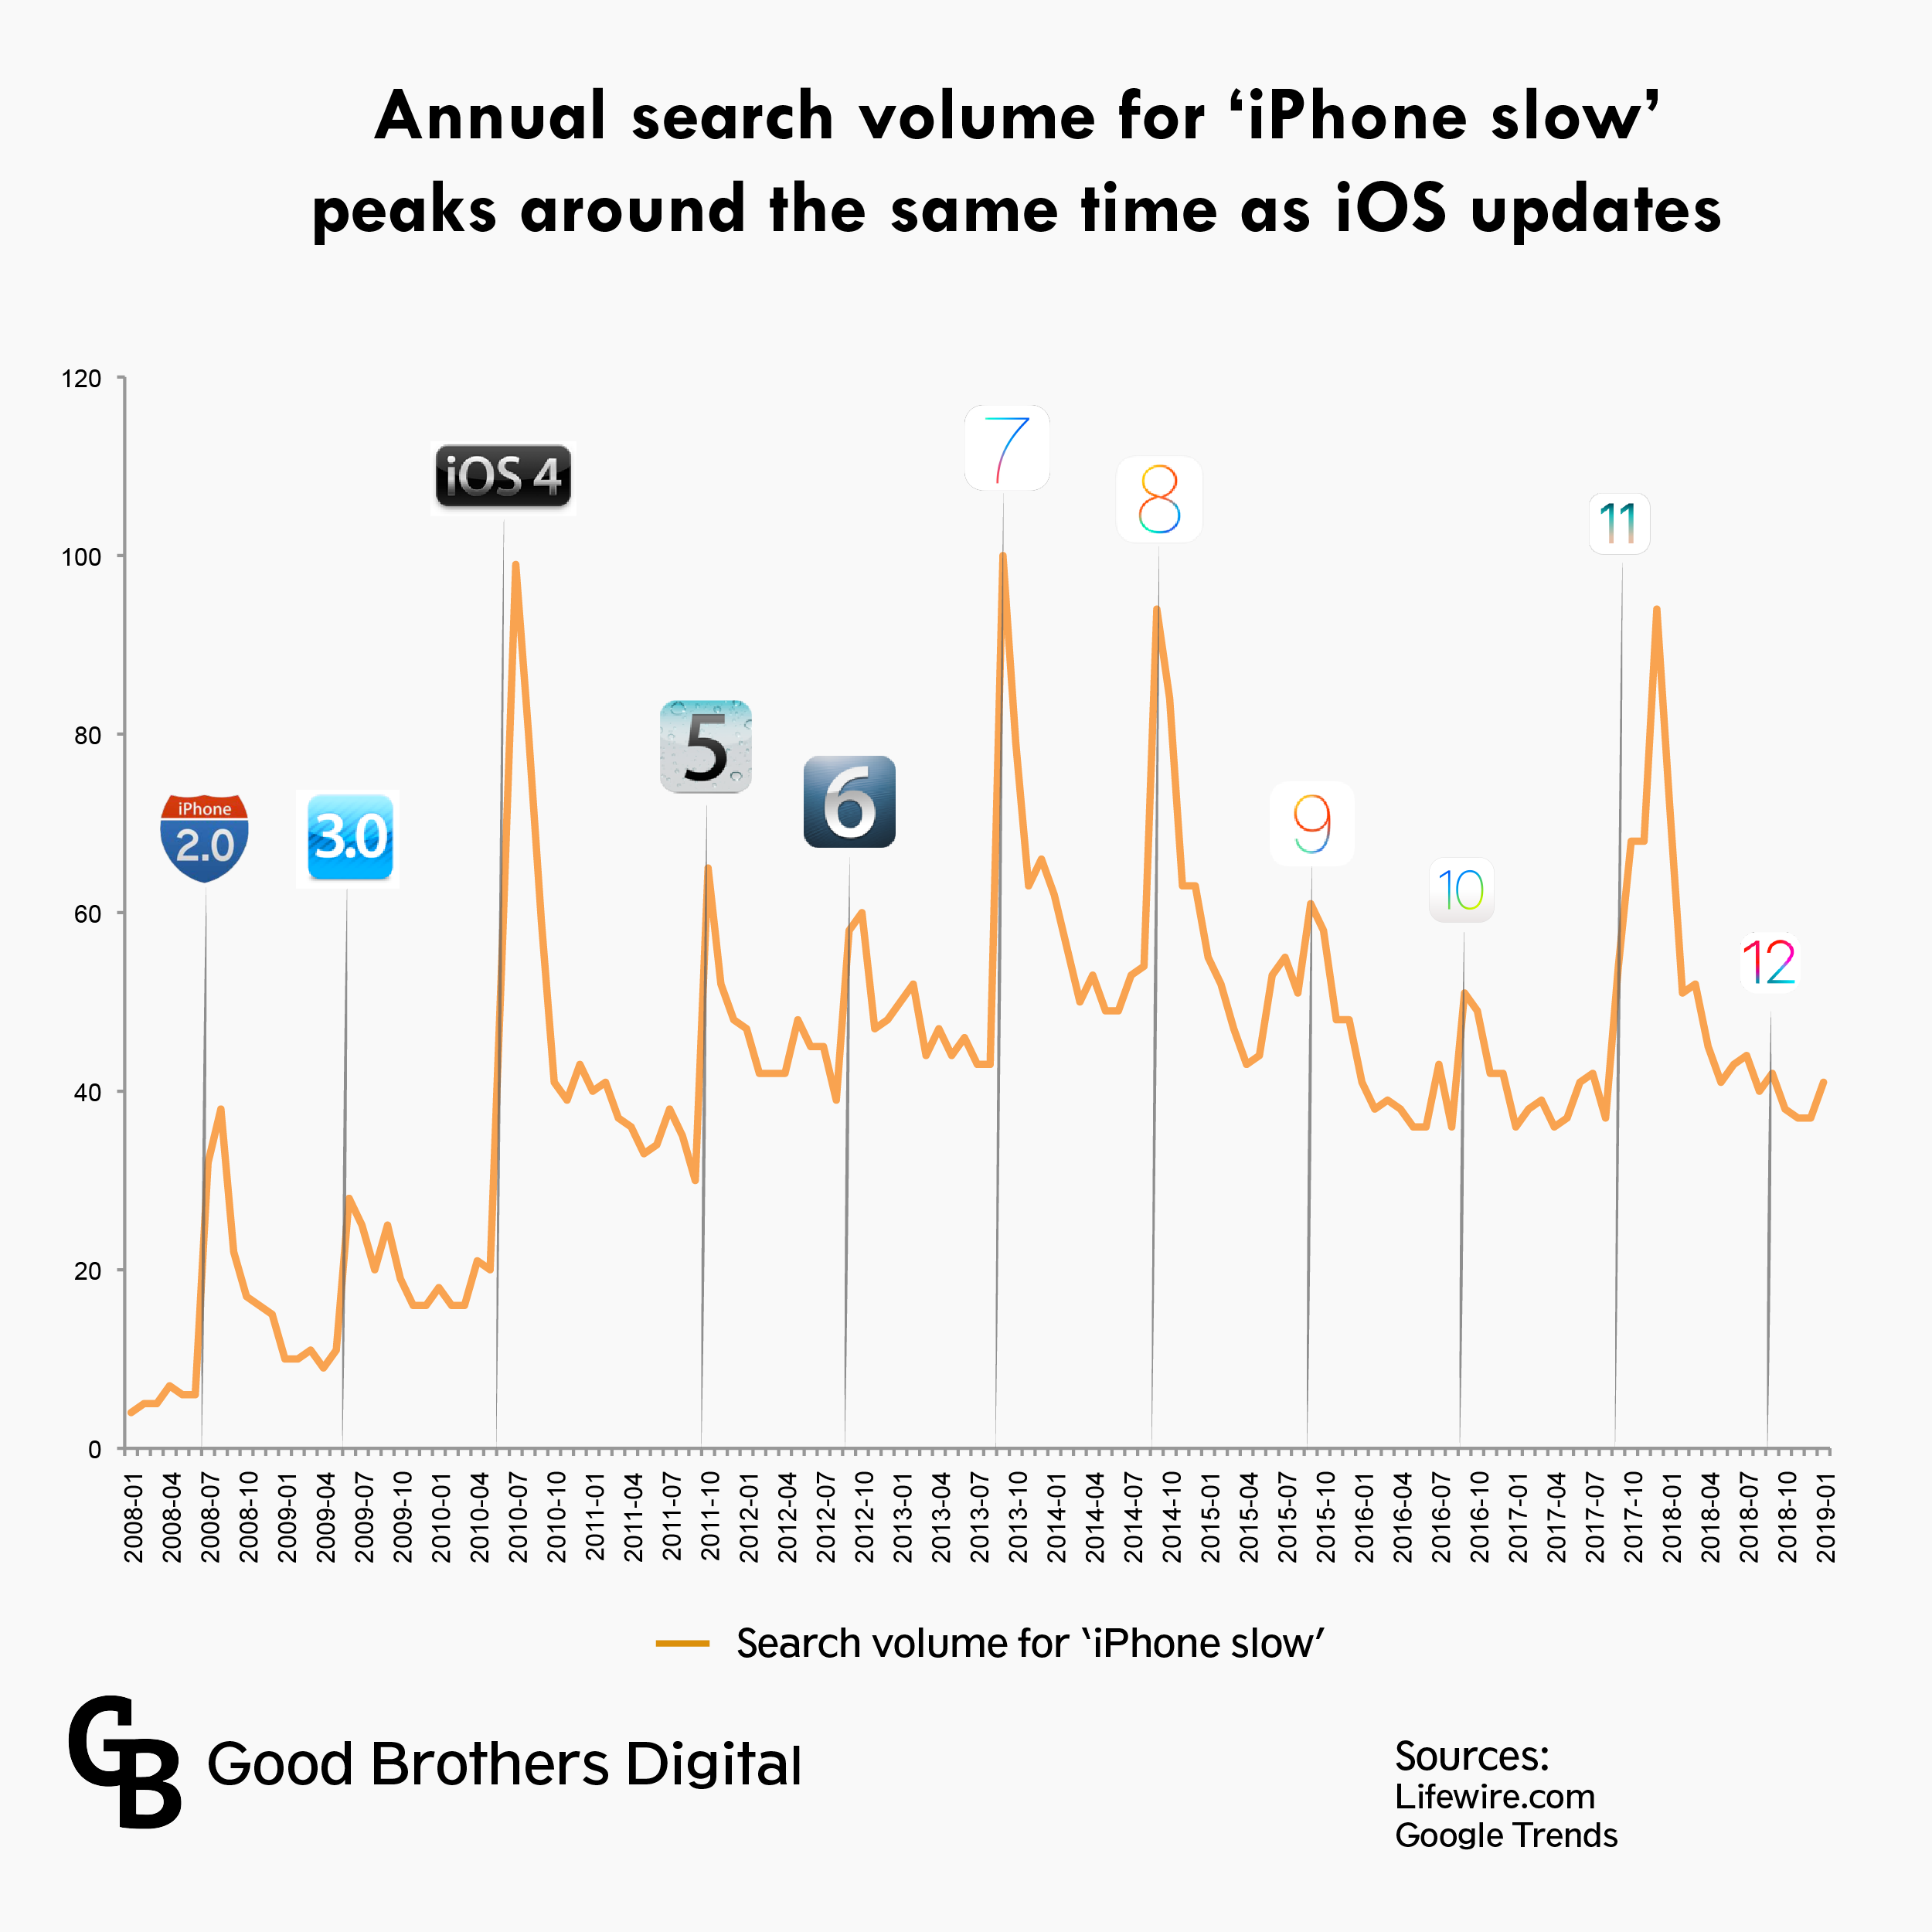

Wyraźnie widać, że wraz z każdą nową wersją IOS (poza 12), pojawia się wyraźny wzrost zapytań.

#### Znajdowanie przecieków maturlanych
Źródło: https://twitter.com/emocjewsieci/status/1269935336701997056

Po maturze z języka polskiego media zaczęły pisać o możliwym przecieku na podlasiu. Otóż zauważono, przy pomocy Google Trends, że 2 godziny przed rozpoczęciem egzaminu znacznie wzrosła popularność hasła "elementy fanstastyczne w weselu" i haseł pokrewnych. Jak się okazało, był to temat rozprawki na maturze.

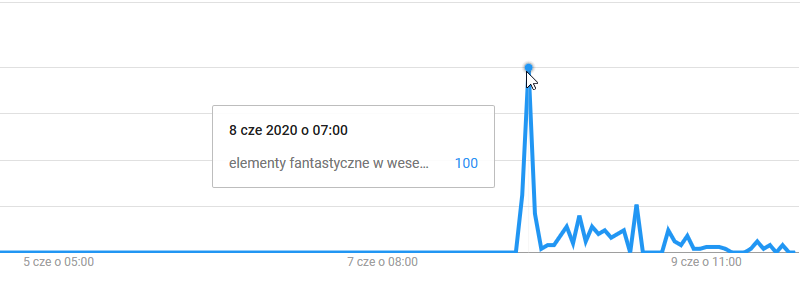

### Wnioski końcowe
Dane z Google Trends możemy wykorzystać na multum sposobów. Obserwowanie przemian społecznych, analiza różnic kulturowych czy badanie kształtowania się trendów to tylko niektóre z wielu zastosowań. Hasła, które wyszukujemy, w pewnym stopniu nakreślają obraz całego społeczeństwa - jakie są nasze preferencję, jak się zmieniają w czasie, jak się kształtują względem innych krajów. Analiza danych z Google Trends pozwala zauważyć wiele zależności w społeczeństwie, których nie sposób dostrzec na codzień.